In [1]:
## Plotting history 
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


In [2]:
## Plotting confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_val, y_pred, title):
    y_pred_classes = y_pred
    y_true_classes = y_val

    # Create and plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix:  ' + title)
    plt.show()



In [3]:
import pandas as pd
from datasets import load_dataset


In [4]:
# df = pd.read_csv("../../data/mendeley/HateSpeechDatasetBalanced.csv")
# df.columns = df.columns.str.lower()

dataset = load_dataset('csv', data_files='../../data/mendeley/HateSpeechDatasetBalanced.csv')


In [5]:
dataset = dataset['train'].train_test_split(test_size=0.2)


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 580895
    })
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 145224
    })
})

In [13]:
## preprocess data

from transformers import  DistilBertForSequenceClassification, DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def encode(examples):
    # Tokenize the inputs and add the labels
    encodings = tokenizer(examples['Content'], truncation=True, padding='max_length', max_length=512)
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'], 'labels': examples['Label']}

train_dataset = dataset['train'].map(encode, batched=True)
test_dataset = dataset['test'].map(encode, batched=True)

# Format the dataset to output PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/580895 [00:00<?, ? examples/s]

Map:   0%|          | 0/145224 [00:00<?, ? examples/s]

In [18]:
train_dataset_reduced = train_dataset.shuffle(seed=42).select(range(10000))

In [21]:
## finetune with 3 epochs 

from transformers import Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

training_args = TrainingArguments(
    output_dir='../../models/bert_mendeley_hatespeech_finetuned/results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='../../models/bert_mendeley_hatespeech_finetuned/logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_reduced,
    eval_dataset=test_dataset,
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
trainer.train()

  0%|          | 0/625 [00:00<?, ?it/s]

{'loss': 0.4989, 'grad_norm': 4.607999324798584, 'learning_rate': 5e-05, 'epoch': 0.8}
{'train_runtime': 40003.8517, 'train_samples_per_second': 0.25, 'train_steps_per_second': 0.016, 'train_loss': 0.4779757568359375, 'epoch': 1.0}


TrainOutput(global_step=625, training_loss=0.4779757568359375, metrics={'train_runtime': 40003.8517, 'train_samples_per_second': 0.25, 'train_steps_per_second': 0.016, 'total_flos': 1324673986560000.0, 'train_loss': 0.4779757568359375, 'epoch': 1.0})

In [26]:
import torch

# Save the train and test datasets
torch.save(train_dataset, '../../preprocessed/final_bert_train_dataset.pt')
torch.save(test_dataset, '../../preprocessed/final_bert_test_dataset.pt')

In [27]:
trainer.save_model("../../models/bert_mendeley_hatespeech_finetuned/trainer")
tokenizer.save_pretrained("../../models/bert_mendeley_hatespeech_finetuned/tokenizer")

('../../models/bert_mendeley_hatespeech_finetuned/tokenizer\\tokenizer_config.json',
 '../../models/bert_mendeley_hatespeech_finetuned/tokenizer\\special_tokens_map.json',
 '../../models/bert_mendeley_hatespeech_finetuned/tokenizer\\vocab.txt',
 '../../models/bert_mendeley_hatespeech_finetuned/tokenizer\\added_tokens.json',
 '../../models/bert_mendeley_hatespeech_finetuned/tokenizer\\tokenizer.json')

In [28]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("../../models/bert_mendeley_hatespeech_finetuned/trainer")
tokenizer = DistilBertTokenizerFast.from_pretrained("../../models/bert_mendeley_hatespeech_finetuned/tokenizer")


In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch
import random
from tqdm import tqdm

# Load saved test dataset
loaded_test_dataset = torch.load('../../preprocessed/final_bert_test_dataset.pt')

num_samples = int(len(loaded_test_dataset) * 0.01)

# Randomly select 1% of the data
random_indices = random.sample(range(len(loaded_test_dataset)), num_samples)
reduced_test_dataset = [loaded_test_dataset[i] for i in random_indices]

# Predict the classes for all the texts in the test dataset
test_preds = []
test_labels = []

for item in tqdm(reduced_test_dataset, desc='Predicting on 1% of test data'):
    inputs = {key: item[key].unsqueeze(dim=0) for key in ['input_ids', 'attention_mask']}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probs).item()
    test_preds.append(predicted_class)
    test_labels.append(item['labels'].item())

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Generate a classification report
report = classification_report(test_labels, test_preds)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Predicting on 1% of test data: 100%|██████████| 1452/1452 [41:37<00:00,  1.72s/it]

Confusion Matrix:
[[579 141]
 [106 626]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       720
           1       0.82      0.86      0.84       732

    accuracy                           0.83      1452
   macro avg       0.83      0.83      0.83      1452
weighted avg       0.83      0.83      0.83      1452



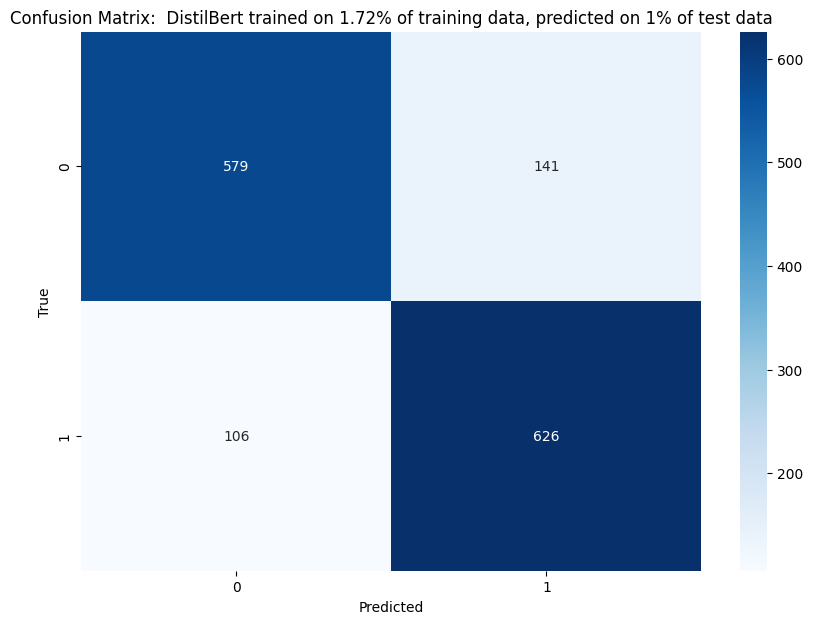

In [37]:
percent_used = 10000/580895
plot_confusion_matrix(test_labels, test_preds, f"DistilBert trained on {percent_used*100:.2f}% of training data, predicted on 1% of test data")